## Allan Deviation - Statistics

In [4]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import allantools

from andbro__querrySeismoData import __querrySeismoData
from andbro__read_sds import __read_sds

In [8]:
from functions.load_beat_data import __load_beat_data
from functions.get_time_intervals import __get_time_intervals
from functions.get_median import __get_median
from functions.get_minimum import __get_minimum
from functions.get_percentiles import __get_percentiles
from functions.load_mlti import __load_mlti
# from functions.get_mlti_intervals import __get_mlti_intervals
# from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN


In [5]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [92]:
## Configuration
config = {}

## specify data type
config['datatype'] = "rotation_rate" ## raw | rotation_rate | beat

## specify time series interval
config['tbeg'] = obs.UTCDateTime("2024-01-13 00:00")
config['tend'] = obs.UTCDateTime("2024-01-17 00:00")

config['tbeg'] = obs.UTCDateTime("2024-04-20 00:00")
config['tend'] = obs.UTCDateTime("2024-04-25 00:00")

# config['seed'] = "BW.ROMY.10.BJZ"
# config['seed'] = "BW.ROMY..BJU"
config['seed'] = "BW.ROMY..BJV"
# config['seed'] = "BW.RLAS..BJZ"

config['repository'] = "archive"

config['path_to_figures'] = data_path+"allan_deviation/figures/"

config['path_to_data_out'] = data_path+"allan_deviation/data/"

config['net'], config['sta'], config['loc'], config['cha'] = config['seed'].split(".")

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_sds'] = archive_path+"romy_archive/"

config['sagnac_rings'] = {"Z":553.5, "U":303.05, "V":447, "W":447}
config['nominal_sagnac'] = config['sagnac_rings'][config['seed'][-1]]

## ALLAN

## show error bars
config['errorbars'] = False

## plot rotation rate relative to 2pi/86400
config['relative'] = False

## tau intervale
config['tau'] = 'all' ## all, octave, decade

## type of allan deviation
config['method'] = 'adev' ## adev, oadev, mdev

## phase or frequency
config['intype'] = "freq"

## Load Data

### import raw sagnac data

In [93]:
if config['datatype'] == "raw":

    st = __read_sds(archive_path+"romy_archive", "BW.DROMY..FJZ", config['tbeg'], config['tend'])

    for tr in st:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

        ## convert from Hz to rad/s with scale factor
        # tr.data = tr.data/10182093.88

    st

### import sagnac frequency

In [94]:
if config['datatype'] == "beat":

    data = __load_beat_data(config['tbeg'], config['tend'], config['cha'][2], config['path_to_autodata'])

    tr = obs.Trace()
    tr.data = np.array(data.fj)
    tr.stats.delta = 1.0
    tr.stats.starttime = obs.UTCDateTime(config['tbeg'])
    st = obs.Stream(tr)

    st[0].data = (st[0].data - config['nominal_sagnac']) / config['nominal_sagnac']
    # st[0].data = (st[0].data - np.mean(st[0].data) / np.mean(st[0].data))

    ## convert from Hz to rad/s with scale factor
    S = 10182093.88
    S = np.sqrt(3)/3 * 12.0 / 632.8e-9
    tr.data = tr.data/S

    st.plot();

### import rotation rate data

1 Trace(s) in Stream:
BW.ROMY..BJV | 2024-04-19T23:59:49.990600Z - 2024-04-25T00:00:09.990600Z | 20.0 Hz, 8640401 samples

1 Trace(s) in Stream:
BW.ROMY..BJV | 2024-04-19T23:59:59.990600Z - 2024-04-24T23:59:59.990600Z | 20.0 Hz, 8640001 samples

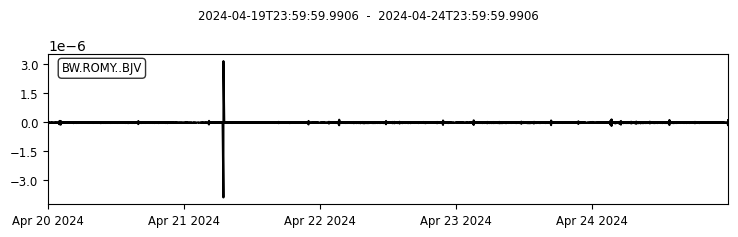

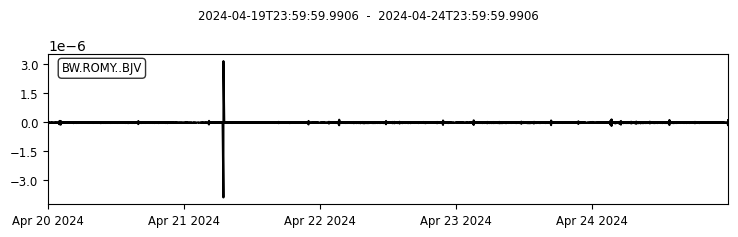

In [95]:
if config['datatype'] == "rotation_rate":

    st = __read_sds(config['path_to_sds'], config['seed'], config['tbeg']-10, config['tend']+10)

    if "ROMY" in config['seed']:
        inv = obs.read_inventory(root_path+"Documents/ROMY/stationxml_ringlaser/dataless/dataless.seed.BW_ROMY")
    elif "RLAS" in config['seed']:
        inv = obs.read_inventory(root_path+"Documents/ROMY/stationxml_ringlaser/dataless/dataless.seed.BW_RLAS")

    # st.detrend("demean");

    st.remove_sensitivity(inv);

    st.trim(config['tbeg'], config['tend']);

    ## convert from Hz to rad/s with scale factor
    # st[0].data = st[0].data * 10182093.88 * 2*np.pi/86400

    st.plot();

## Compute Allan Dev

In [96]:
## define tau range e.g. 5 (= 10⁵) and number of samples N
upper = 6
lower = -4
N = 150

## list of tau values in seconds
taux = np.logspace(lower, upper, N)

## smallest sampling in seconds
dtaux = taux[1]-taux[0]

## sampling rate
df = st[0].stats.sampling_rate

In [97]:
config['interval_seconds'] = 3600*4
config['interval_overlap'] = 0.5

times = __get_time_intervals(config['tbeg'], config['tend'], config['interval_seconds'], config['interval_overlap'])

In [98]:
mlti = __load_mlti(config['tbeg'], config['tend'], config['seed'][-1], archive_path)

In [99]:
## normal allan deviation; allan object = (taus1, adevs1, errors, ns)

from tqdm.notebook import tqdm

mlti_counter = 0

_adev, _error = [], []
for t1, t2 in tqdm(times):

    ## check for MLTI
    mlti_found = False
    for t_mlti in mlti.time_utc:
        if t_mlti > t1 and t_mlti < t2:
            # print(f" MTLI found. Abort!")
            mlti_counter += 1
            mlti_found = True
            break

    if mlti_found:
        continue

    st0 = st.copy()

    st0 = st0.trim(t1, t2)

    # st0 = st0.detrend("demean")

    if config['method'] == "oadev":
        allan = allantools.oadev(st0[0].data,
                                 data_type=config['intype'],
                                 rate=df,
                                 taus=config['tau'],
                                 )

    elif config['method'] == "mdev":
        allan = allantools.mdev(st0[0].data,
                                data_type=config['intype'],
                                rate=df,
                                taus=config['tau'],
                                )

    elif config['method'] == "adev":
        allan = allantools.adev(st0[0].data,
                                data_type=config['intype'],
                                rate=df,
                                taus=config['tau'],
                                )
    if len(allan[1]) == 96000:
        _adev.append(allan[1])
        _error.append(allan[2])

print(f" -> MLTI count: {mlti_counter}")

  0%|          | 0/30 [00:00<?, ?it/s]

 -> MLTI count: 1


In [100]:
tau = allan[0]
adev = np.array(_adev)
error = np.array(_error)

In [101]:
adev_perc_low, adev_perc_high = __get_percentiles(adev, p_low=2.5, p_high=97.5)

In [102]:
adev_median = __get_median(adev)

In [103]:
adev_minimum = __get_minimum(adev, tau)

## Plotting

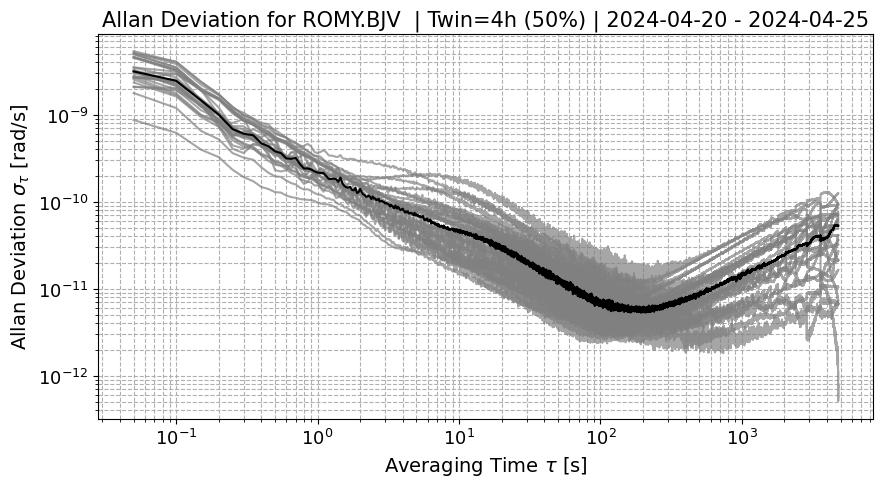

In [104]:
def __makeplot_allan_deviation_statistics():

    # taus, adev, errors, ns = allan[0], allan[1], allan[2], allan[3]

    day = st[0].stats.starttime.date
    tt1 = str(st[0].stats.starttime.time)[:8]
    tt2 = str(st[0].stats.endtime.time)[:8]


    ## -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    font = 14

    for _adev, _err in zip(adev, error):
        if config['errorbars']:
            ax.scatter(tau, _adev, color='grey', zorder=2, alpha=0.7)
            ax.errorbar(tau, _adev, yerr=_err, color='darkred', fmt='none', zorder=1)
        else:
            ax.plot(tau, _adev, color='grey', alpha=0.7)

    ## add median
    ax.plot(tau, adev_median, color='black')

    ## add minimum
    # ax.plot(tau, adev_minimum, color='black')

    ## add percentiles
    # ax.fill_between(tau, adev_perc_low, adev_perc_high, color='lightgrey')

    ax.set_title(f"Allan Deviation for {config['sta']}.{config['cha']}  | Twin={int(config['interval_seconds']/3600)}h ({int(config['interval_overlap']*100)}%) | {config['tbeg'].date} - {config['tend'].date}", fontsize=font+1)
    ax.set_xlabel(r"Averaging Time $\tau$ [s]", fontsize=font)

    if config['relative']:
        ax.set_ylabel(r"Allan Deviation  $\Omega$/$\Omega_E$", fontsize=font)
    else:
        ax.set_ylabel(r"Allan Deviation $\sigma_{\tau}$ [rad/s]", fontsize=font)

    ax.set_xscale('log')
    ax.set_yscale('log')

    # ax.legend(fontsize=font-2)

    ax.grid(True, which="both", ls="--")

    ax.tick_params(labelsize=font-1)

    plt.show();
    return fig

fig = __makeplot_allan_deviation_statistics()

fig.savefig(config['path_to_figures']+f"AD_{config['seed'].split('.')[1]}_{config['cha'][-1]}_statistics.jpeg", format="jpeg", dpi=150, bbox_inches='tight')


## Store Allan

In [105]:
from andbro__store_as_pickle import __store_as_pickle

In [106]:
out_adev = {}
out_adev['tau'] = allan[0]
out_adev['adev'] = allan[1]
out_adev['error'] = allan[2]
out_adev['ns'] = allan[3]
out_adev['tbeg'] = config['tbeg']
out_adev['tend'] = config['tend']
out_adev['seed'] = config['seed']
out_adev['adevs'] = adev
out_adev['adev_median'] = adev_median
out_adev['adev_minimum'] = adev_minimum

fname = f"ADev_{config['seed'].split('.')[1]}_{config['seed'][-1]}_{config['tbeg'].date}.pkl"
__store_as_pickle(out_adev, config['path_to_data_out']+fname)
print(f" -> stored: {fname}")

 -> stored: ADev_ROMY_V_2024-04-20.pkl


## Plot Mutli Allan

In [42]:
from pandas import read_pickle

In [43]:
# adev_Z = read_pickle(config['path_to_data_out']+"ADev_Z_2023-09-19.pkl")
# adev_U = read_pickle(config['path_to_data_out']+"ADev_U_2023-09-19.pkl")
# adev_V = read_pickle(config['path_to_data_out']+"ADev_V_2023-09-19.pkl")

adev_Z = read_pickle(config['path_to_data_out']+"ADev_Z_2024-04-20.pkl")
adev_U = read_pickle(config['path_to_data_out']+"ADev_U_2024-04-20.pkl")
adev_V = read_pickle(config['path_to_data_out']+"ADev_V_2024-04-20.pkl")


allans = [adev_Z, adev_U, adev_V]

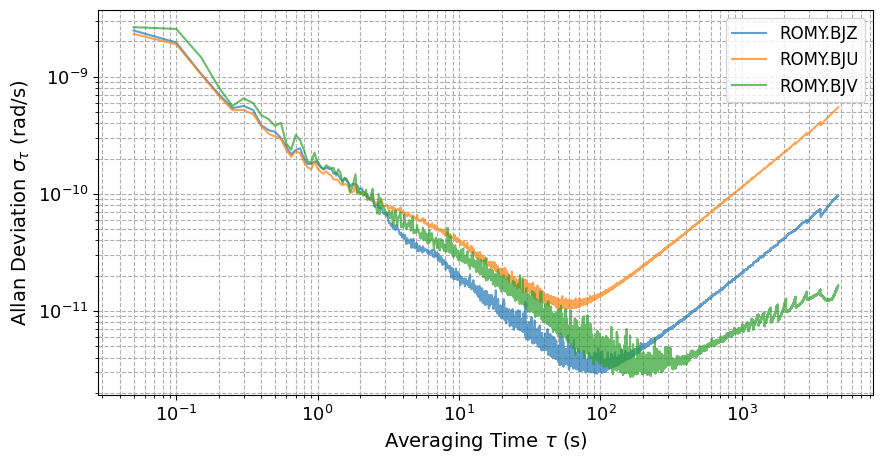

In [44]:
def __makeplot_allan_deviation_rings(allans, errorbars=False):

    # taus, adev, errors, ns = allan[0], allan[1], allan[2], allan[3]

    # day = st[0].stats.starttime.date
    # tt1 = str(st[0].stats.starttime.time)[:8]
    # tt2 = str(st[0].stats.endtime.time)[:8]

    # if config['relative']:
    #     adev = adev / 7.3e-5

    ## -------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    font = 14

    for _allan in allans:
        taus = _allan['tau']
        adev = _allan['adev']

        net, sta, loc, cha = _allan['seed'].split(".")

        if errorbars:
            ax.scatter(taus, adev, color='darkred', label=f"{sta}.{cha}", zorder=2)
            ax.errorbar(taus, adev, yerr=allan[2], color='darkred', fmt='none', zorder=1)
        else:
            ax.plot(taus, adev, label=f"{sta}.{cha}", alpha=0.7)


    # ax.set_title(f"Allan Deviation for {config['net']}.{config['cha']} on {day}  [{tt1}-{tt2} UTC]", fontsize=font+3)
    ax.set_xlabel(r"Averaging Time $\tau$ (s)", fontsize=font)

    if config['relative']:
        ax.set_ylabel(r"Allan Deviation  $\Omega$/$\Omega_E$", fontsize=font)
    else:
        ax.set_ylabel(r"Allan Deviation $\sigma_{\tau}$ (rad/s)", fontsize=font)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend(fontsize=font-2)

    ax.grid(True, which="both", ls="--")

    ax.tick_params(labelsize=font-1)

    plt.show();
    return fig

fig = __makeplot_allan_deviation_rings(allans)

fig.savefig(config['path_to_figures']+f"ADev_ROMY_rings.jpeg", format="jpeg", dpi=150, bbox_inches='tight')
